# Introduction to Plotting and Fitting

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)
- Étienne Bourbeau (Niels Boh Institute)

### Date:    
- 08-11-2020 (latest update)

***

This is an introduction on how to use the Python packages iminuit to do fitting, and matplotlib to plot the results nicely.

***

First, we import the modules we want to use:

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

The above block imports packages written by others. But you may want to include your own code from some external file, which holds your custom/favorite functions. This is done as follows, and refers to the Python file called `ExternalFunctions.py` located in the Folder `External_Functions` right next to `Week0`, `Week1` etc:

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

# In case you want to load function from a jupyter notebook from the current working directory, you can use the function below:
#   from ipynb.fs.full.ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

Here we set the random seed for the random number generator (RNG). This ensures reproducability (the same results every time the notebook is restarted). 

In [3]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

We then set some plotting settings (where can for example take advantage of Seaborn's plotting capabilities):

In [4]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

Finally we define some global constants that we are going to use throughout the notebook:

In [5]:
save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

## Create the data:

We create some normally distributed data. First we define the number of random points to produce:

In [6]:
Npoints = 10000 # Number of random points produced

We then fill the created arrays with random numbers:

In [7]:
# Numpy-version:
x_all = r.normal(loc=-0.5, scale=0.8, size=Npoints)
y_all = r.normal(0.5, 1.3, Npoints)

print(x_all)

[-0.10262868 -0.61061144  0.01815083 ... -1.06425338 -0.10338754
  0.01551076]


Where we have shown that you can use keywords (e.g. `loc=-0.5` to indicate the location of the normal distributuion) in the functions to make it easier to read. Available keywords can be seen running `?r.normal()` in a cell.

In [8]:
# ?r.normal() # comment this line in

## Histogram of data (1D):

In the following section, we want to produce two histograms (of normal distributions in this case), and plot them together in a single plot.  
This can be done in two ways!  

The first method is very MatLab-like, and probably also the simplest, but in the longer run has a few drawbacks, while the second method is more pythonic (i.e. object oriented, OO), and allows for returning to these plots later in the code.

First we define the number of bins for the histograms to use along with the minimum and maximum values of x:

In [9]:
# General input (for both methods):
Nbins = 100
xmin, xmax = -5, 5

### Note on binning:
It is very important to specify - in a well thought manner - the range and binning to use. Many problems could have been avoided by a few minutes (or even seconds!) of consideration from the beginning. 

#### Method 0 (MatLab-like)

The Matlab-like way of making plots is to simply to call `plt.plotmethod_name_here(keywords_here)`. Below we first create an empty figure, then fill it with two histograms and lastly we set the text properties (labels, title and legend):

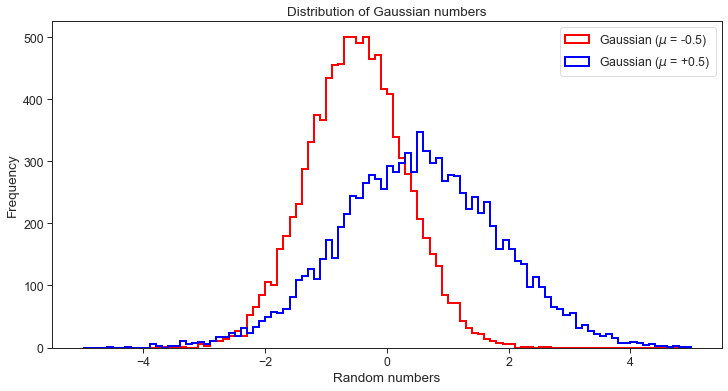

In [10]:
# create just a single figure and axes
plt.figure(figsize=(12, 6)) # figsize is in inches

# create a histogram with Nbin anount  of bins in the range from xmin to xmax.
# Choose a step-type histogram with a line width of 2 in the color and label chosen.
plt.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Gaussian ($\mu$ = -0.5)')
plt.hist(y_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='blue', label='Gaussian ($\mu$ = +0.5)')

plt.xlabel("Random numbers") # the label of the x axis
plt.ylabel("Frequency") # the label of the y axis
plt.title("Distribution of Gaussian numbers") # the title of the plot
plt.legend(loc='best'); # could also be # loc = 'upper right' e.g.

We end the last line with a semicolon (`;`) above to suppress the output since we only want to see the actual figure and not anything else.

#### Method 1 (Python-like)

In this second method we start out by creating a figure and axis handle that contain everything we need about the plot. Each figure can contain several axes (subplots). This way we can fill each axis - e.g. with histograms of the data: 

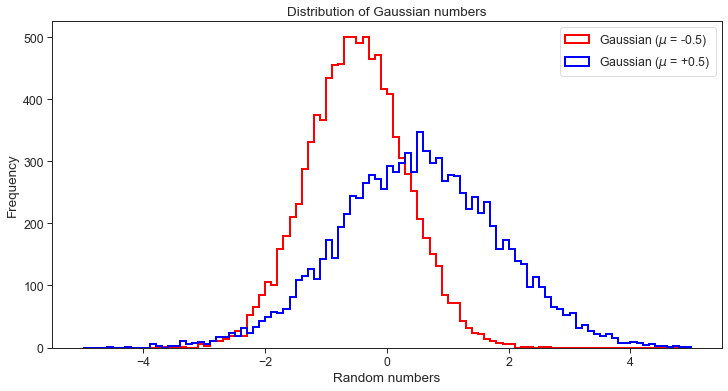

In [11]:
# create just a single figure and axes
fig, ax = plt.subplots(figsize=(12, 6))  # figsize is in inches

# create a histogram and give it a name.
# It has with Nbin anount of bins in the range from xmin to xmax.
# Choose a step type histogram with a line width of 2 in the color and label chosen.
hist1 = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Gaussian ($\mu$ = -0.5)')
hist2 = ax.hist(y_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='blue', label='Gaussian ($\mu$ = +0.5)')

# set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Random numbers", # the label of the y axis
       ylabel="Frequency",  # the label of the y axis
       title="Distribution of Gaussian numbers") # the title of the plot
ax.legend(loc='best'); # could also be # loc = 'upper right' e.g.

As can be seen, the two figures are exactly the same. Sometimes it is quicker to play around with the `plt`-method of plotting in the beginning of a plot, but for more advanced plots the pythonic/OO-method (the one with `ax`) is recommended. 

## Fit to the data / histogram (1D):

Having created the data, we also want to be able to fit the distributions. We first define the function, a Gaussian PDF in this case:

In [12]:
# Define your PDF:
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-0.5 * (x - mu)**2 / sigma**2)

In [13]:
# Define your actual fitting function, which is NOT normalised, but made to fit/model a distribution in a histogram:
def gauss_extended(x, N, mu, sigma) :
    """Non-normalized (extended) Gaussian"""
    return N * gauss_pdf(x, mu, sigma)

Having defined our fitting function, we also want to make a *binned likelihood* fit of `gauss_extended` to the data `x_all`. What a binned likelihood-fit (and all the other types of fits in this section) is exactly you'll learn more about during the course. It is important to use the same bins and bounds as the original histogram. In this case we are also treating the number of events/random numbers as being a fit variable which makes this a so-called *extended fit* (more on that later as well).   
***
We initialize our fitting object, `binned_likelihood`, by using the `BinnedLH` function from probfit. This first takes the function to fit as input, then the input data and finally other fitting options such as the number of bins, the bounds and whether or not it is an extended fit):

In [14]:
binned_likelihood = BinnedLH(gauss_extended, 
                             x_all,
                             bins=Nbins, 
                             bound=(xmin, xmax),
                             extended=True)
# extended=True: this means that we let the number of events N be a variable as well
# extended=False: this means that we have a fixed number of events, N.

Now we are ready to fit `binned_likelihood`. This is done using __[iMinuit](https://iminuit.readthedocs.io/en/latest/)__ which is a Python-wrapper for the wonderful minimization tool Minuit developed by CERN. We can help and constrain the fit in several ways. Minuit allows one to specify the (crucial!) initial guess/estimate of the parameters' values, the range allowed for the values and has the ability to fix certain parameters' values to constant values. Let's start with a basic example:

In [15]:
minuit = Minuit(binned_likelihood, mu=-1, sigma=1, N=1000, pedantic=False, print_level=1)

Here we tell Minuit that we want to minimize the `binned_likelihood` object, tells it the initial values for `mu`, `sigma` and `N` and finally disables some automatic warnings that Minuit shows (which are unimportant in most cases). In the text below here we show how to implement the ranges of the parameters and how to fix variables:

``` 
minuit = Minuit(binned_likelihood, mu=-1, sigma=1, N=1000, pedantic=False, 
                limit_sigma = (0,10)  # set the range for sigma to be between 0 and 10
                fix_N=True # fix the value of N to its initial value (1000)
                )
```

We now let Minuit actually run the fitting routine:

In [16]:
minuit.migrad();  # perform the actual fit

../../../External_Functions/ExternalFunctions.py:253: UserWarning: x is really small return 0
  warnings.warn('x is really small return 0')


------------------------------------------------------------------
| FCN = 28.07                   |     Ncalls=106 (106 total)     |
| EDM = 7.92e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


When run in a notebook, we get a very nice overview of the fit results.  

1. The first table shows the likelihood/Chi2 function value (around 20ish), the total number of calls (around 100ish) during the fit along with some other metrics indicating the distance to the (estimated) global minimum.   
2. The second table shows the validity of the fit (in some versions indicated by all the green squares). It is always important to check that the fit converged!  
3. The table below shows the fitted parameters' values along with their uncertainties. These uncertainties are super important (!) and the primary reason why we are not using the minimizer found in scipy (because scipy does not provide uncertainty bounds on general minimization estimates**).

**Well, a subject of discussion!

Below we show how to extract the values into variables which we can use further on and print the values:

In [17]:
fit_N, fit_mu, fit_sigma = minuit.args # the fitted values of the parameters
for name in minuit.parameters:
    value, error = minuit.values[name], minuit.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")
    
LLH_value = minuit.fval # the LogLikeliHood (LLH) value
print(LLH_value)

Fit value: N = 10000.06432 +/- 100.00064
Fit value: mu = -0.50167 +/- 0.00803
Fit value: sigma = 0.80229 +/- 0.00568
28.06912298631734


Let's see if the fitted values actually match the distribution. This is always an important check to make as our eyes are extremely good at estimating the goodness of a fit (compared to just seeing some numbers). This also serves an extra check of the code, since sometimes you've made an error in the code which suddenly becomes very visible when plotted.

Since we are dealing with binned data, we have to take the binwidth into account. This is calculated as: $\text{binwidth} = \frac{\Delta x}{\text{Nbins}}$. We then multiply the fitted (y) values with the binwidth to get matching scales in the plot and plot the fit in the the `ax` object from the figure above:

In [18]:
binwidth = (xmax-xmin) / Nbins # the scale factor between the histogram and the fit. Takes bin width into account.
x_fit = np.linspace(-5, 5, 1000) # Create the x-axis for the plot of the fitted function
y_fit = binwidth*gauss_extended(x_fit, fit_N, fit_mu, fit_sigma) # the fitted function

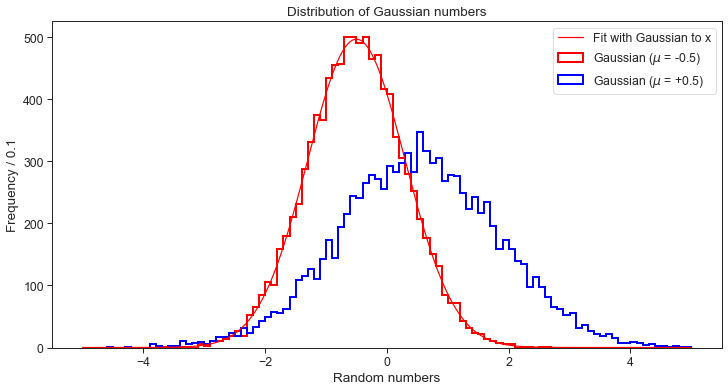

In [19]:
ax.plot(x_fit, y_fit, '-', color='red', label='Fit with Gaussian to x')
ax.set(ylabel=f"Frequency / {binwidth}")
ax.legend(loc='upper right')          # Here we don't put any ";", as fig is the last command, which does not give any output.
fig

Note, we refer to the old figure `fig`. Had we done another plot in between, we would not have been able to plot on top of the old figure with the matlab syntax.

Note, had we wanted to plot either of the histograms as errorbars, we would have needed the following:  

```
y, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax), normed=False)
x = 0.5*(bin_edges[:-1] + bin_edges[1:])
sy = np.sqrt(y)
hist1 = ax.errorbar(x, y, sy, fmt='.', label='Gaussian number distribution')
```


## Get statistics

In this section we calculate the needed statistical values for the fit. First we extract the x and y values of the histogram and assume Poisson statistics to calculate the uncertainties:

In [20]:
entries, bin_edges, _ = hist1
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

hist1_x = bin_centers 
hist1_y = entries
hist1_sy = np.sqrt(hist1_y)

We then calculate the chi squared value ($\chi^2$). Remember that $\chi^2$ is calculated as: 
\begin{equation*}
\chi^2 = \sum_{i}^{N} \frac{(y_i - f(x_i))^2}{\sigma_i^2}
\end{equation*}

In [21]:
# Here we calculate the chi2 value of the fit and the number of non-empty bins
chi2_val = 0
N_NotEmptyBin = 0

for x, y, sy in zip(hist1_x, hist1_y, hist1_sy):
    if y > 0:
        f = binwidth * gauss_extended(x, fit_N, fit_mu, fit_sigma) # calc the model value
        chi2_val  += (y - f)**2 / sy**2  # calulate the chi2 value
        N_NotEmptyBin += 1 # count the bin as non-empty since y>0 (and thus sy>0)

Above we have shown how do calculate $\chi^2$ in a loop-oriented way for pedagogical reasons. This, however, is usually not the optimal way of utilizing Numpy's true power. It can be computationally optimized by vectorizing the code:

In [22]:
f = binwidth * gauss_extended(hist1_x, fit_N, fit_mu, fit_sigma)
mask_zeroes = (hist1_y > 0)

chi2_val_np = np.sum( (f[mask_zeroes] - hist1_y[mask_zeroes])**2 / hist1_sy[mask_zeroes]**2)
N_NotEmptyBin_np = np.sum(mask_zeroes)

And we can see that the two results are similar (using `np.allclose` to do a boolean comparison of floats):

In [23]:
print(chi2_val)
print(chi2_val_np)
print(np.allclose(chi2_val,chi2_val_np)) # np.allclose to do a boolean comparison of floats
print("")
print(N_NotEmptyBin)
print(N_NotEmptyBin_np)
print(np.allclose(N_NotEmptyBin, N_NotEmptyBin_np))

44.00166597671498
44.00166597671498
True

60
60
True


Below we find the number of degrees of freedom (`N_DOF`), which is the number of data points in the fit (non-empty) minus the number of fitting parameters:

In [24]:
N_DOF = N_NotEmptyBin - len(minuit.args)

Given the $\chi^2$ value and `N_DOF`, we can also calculate the $\chi^2$ probability `chi2_prob`:

In [25]:
chi2_prob = stats.chi2.sf(chi2_val, N_DOF) # The chi2 probability given N_DOF degrees of freedom
chi2_prob

0.8963194893572277

This shows us that there is a 80% probability of obtaining a worse fit just by chance. Or, to quote __[Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution)__: *The p-value is the probability of observing a test statistic at least as extreme in a chi-squared distribution*. But we will talk **a lot** more about p-values and the chi-square distribution later on in the course. 

***

Below we also show how to add all of the above information into the figure as well. We define a dictionary `d` which has the information that we want in the plot in it. It has the names of the different elements as keys and the corresponding numbers as values. In case we want to include numbers as uncertainties, we include them as a length-2 list (see `mu` below). Other than that, the function `nice_string_output` takes care of the rest of the formatting (including floats vs. ints). It allows the user to set a custom amount of spacing, `extra_spacing`, between then names and the numbers in the string and the number of decimals to show, `decimals`. 


In [26]:
d = {'Entries':  len(x_all),
     'Mean':     x_all.mean(),
     'Std':      x_all.std(ddof=1),
     # 'N':        [minuit.values['N'], minuit.errors['N']],
     'mu':       [minuit.values['mu'], minuit.errors['mu']],
     # 'sigma':    [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     chi2_val,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

In [27]:
d['Entries']

10000

Above we have commented out the fitted normalisation `N` and width `sigma` for simplicity, but below we'll show you a way to avoid "manually" writing all parameters by hand. Now we use `nice_string_output` to define the text and then `add_text_to_ax` to add the text to the plot. `fig.tight_layout()` is used to remove unnecessary spacing around the figure in the end. 

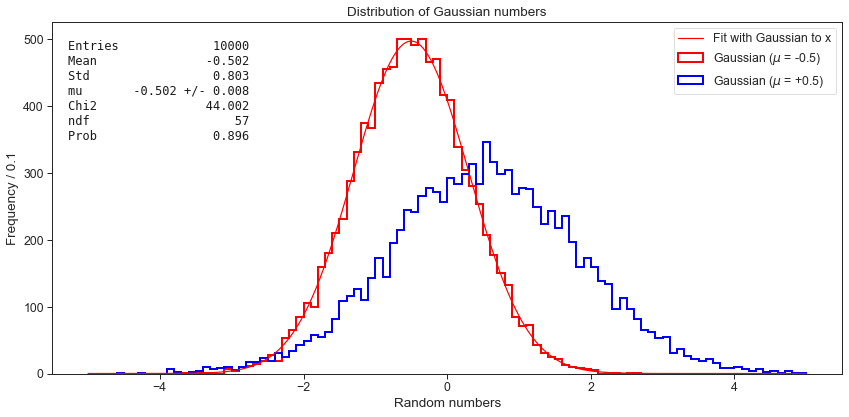

In [28]:
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=12)
fig.tight_layout()
# Note, we refer to the old plot "ax". Had we done another plot inbetween,
# we would not have been able to plot on top of the old figure with the matlab syntax

fig

We now a final, nicely looking plot which we can save for later use, e.g. in a report. We give it a name and specify the resolution with the `dpi` keyword, where 600 is usually a good choice. 

In [29]:
if save_plots:
    fig.savefig('Histogram.pdf', dpi=600)

## Graph with fit (1D):

In addition to fitting a histogram, we sometimes get measurements of both x and y, e.g. measuring the distance versus time, along with their uncertainties. This part of the exercise shows hwo to fit the data in thus cases.
***
We first initialize the needed arrays (all of lenght 51):

In [30]:
# Define points for a graph with errors:
Ndata = 51
x  = np.zeros(Ndata) # create empty arrays to store the numbers in
y  = np.zeros(Ndata)
sx  = np.zeros(Ndata)
sy  = np.zeros(Ndata)

Having defined four arrays filled with zeros, below we fill it with randomly generated values:

In [31]:
x = np.linspace(-1.25, -1.25+0.05*(Ndata-1), Ndata)
y = -2.0 - 2.0*x + 1.0*x*np.sin(x) + 2.0*x**3
y[x>0.0] += 0.5 # added discontinuity at x=0
y += r.normal(0., 0.1, Ndata)
sx = np.zeros(Ndata)
sy = 0.1*np.ones(Ndata)

We now plot the data. Notice that we give the plots new names (`fig2`, `ax2`) so we can differentiate between the old (`fig`, `ax`) and the new plots.

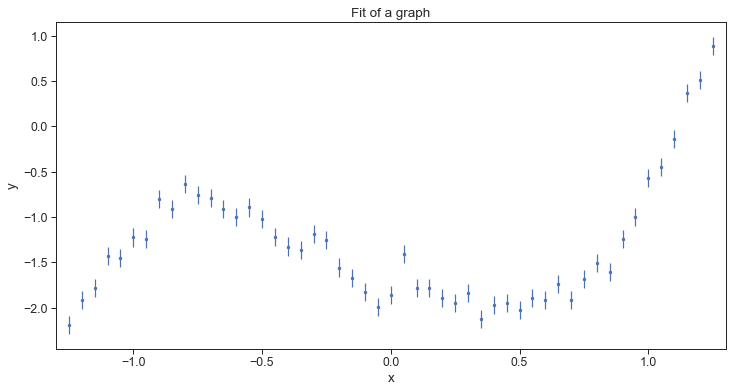

In [32]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.errorbar(x, y, xerr=sx, yerr=sy, fmt='.')
ax2.set(title="Fit of a graph", 
        xlabel="x", 
        ylabel="y",
        xlim=(-1.3, 1.3));

We now try to fit the function $f(x)=p_0 + p_1 x + p_2 x \sin x + p_3 x^3$ to the data. First we define the function:

In [33]:
def func_simple(x, p0, p1, p2, p3):
    return p0 + p1*x + p2*x*np.sin(x) + p3*x*x*x

In this case want to do a chi square ($\chi^2$) fit to the data. We initialize a probfit object with the `Chi2Regression` function:

In [34]:
chi2_object_simple = Chi2Regression(func_simple, x, y, sy)

An alternative option is to write the Chi2 function yourself:

In [35]:
# Defining Chi2 calculation:
def chi2_owncalc(p0, p1, p2, p3) :
    y_fit = func_simple(x, p0, p1, p2, p3)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

We now tell Minuit that we want to minimize `chi2_object_simple` and provide initial guesses for the parameters:

In [36]:
# Using "external functions":
# minuit_simple = Minuit(chi2_object_simple, print_level=1, pedantic=False, p0=0.0, p1=2.0, p2=0.0, p3=2.0)
# Using your own Chi2 function:
minuit_simple = Minuit(chi2_owncalc, print_level=1, pedantic=False, p0=0.0, p1=2.0, p2=0.0, p3=2.0)

minuit_simple.migrad(); # fit

------------------------------------------------------------------
| FCN = 102.5                   |      Ncalls=77 (77 total)      |
| EDM = 6.24e-21 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


It is always a good idea to explicitly check, if the fit converged:

In [37]:
if (not minuit_simple.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

As last time wee see a lot of green indicating that the fit converged - yay! We see the the minimum value, $\chi^2$ in this case, is 73.9, and we see the values of the fit parameters along with their uncertainties. We can also print these parameters as we like it:

In [38]:
p0, p1, p2, p3 = minuit_simple.args
print("Simple fit")
for name in minuit_simple.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_simple.values[name], minuit_simple.errors[name]))

Simple fit
Fit value: p0 = -1.74120 +/- 0.02193
Fit value: p1 = -1.44422 +/- 0.04763
Fit value: p2 = 0.94286 +/- 0.03681
Fit value: p3 = 1.70535 +/- 0.04481


And plot the fit on the same plot as the data (`ax2`):

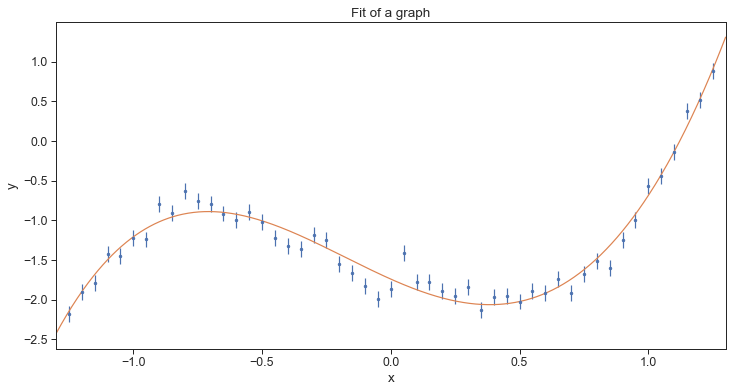

In [39]:
x_fit = np.linspace(-1.3, 1.3, 1000)
y_fit_simple = func_simple(x_fit, p0, p1, p2, p3)
ax2.plot(x_fit, y_fit_simple, '-', label='Simple fit')
fig2

However, we also know that the data was generated with a discontinuity at $x=0$. To fit that, we first define a function that depends on the value of x (piecewise function 'gaffelfunktion'):

In [40]:
# Defining external function (which can include "if" statements and everything else!):
def func_advanced(x, p0, p1, p2, p3, p4) :
    if x > 0:
        return p0 + p1*x + p2*x*np.sin(x) + p3*x**3 + p4
    else:
        return p0 + p1*x + p2*x*np.sin(x) + p3*x**3

The function above accepts only single values for x, ie. not lists/arrays. This is the format that Minuit expects, so this is the function that we are going to use in the fit.  
However, when plotting the data, or simply doing anything other than fitting it with Minuit, we can use Numpy to vectorize the function. Numpy has the function `np.vectorize` which transforms a non-vectorized function to vectorized, such that the output allows x to be a numpy array instead of just a scalar:

In [41]:
func_advanced_vec = np.vectorize(func_advanced)

We will not need `func_advanced_vec` for the fit though, so we continue defining the chi2-fit object using `func_advanced`: 

In [42]:
chi2_object_advanced = Chi2Regression(func_advanced, x, y, sy)

And minimize it:

In [43]:
minuit_advanced = Minuit(chi2_object_advanced, pedantic=False, p0=0., p1=2.0, p2=0.0, p3=2.0, p4=0.5)
minuit_advanced.migrad(); # fit

Printing the fitted paramaters and their uncertainties:

In [44]:
p0, p1, p2, p3, p4 = minuit_advanced.args
print("Advanced fit")
for name in minuit_advanced.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_advanced.values[name], minuit_advanced.errors[name]))

Advanced fit
Fit value: p0 = -1.97602 +/- 0.04181
Fit value: p1 = -1.98853 +/- 0.09527
Fit value: p2 = 0.92754 +/- 0.03688
Fit value: p3 = 1.96610 +/- 0.05975
Fit value: p4 = 0.49336 +/- 0.07479


And plotting it on the data:

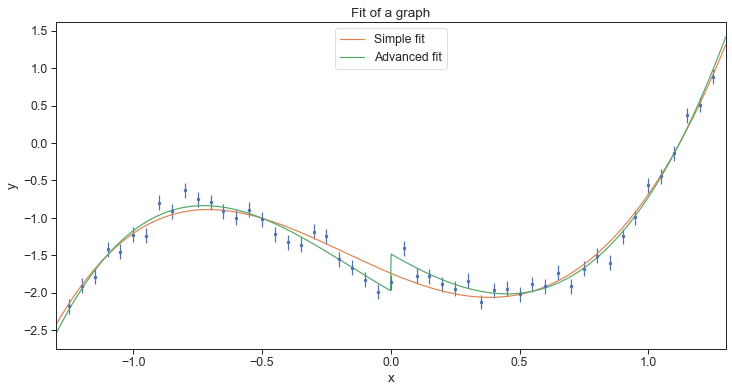

In [45]:
y_fit_advanced = func_advanced_vec(x_fit, p0, p1, p2, p3, p4 )
ax2.plot(x_fit, y_fit_advanced, '-', label='Advanced fit')

ax2.legend(loc='upper center')

fig2

***

#### Advanced hint:

If you have many parameters and don't want to write out all the names (like `p0`, `p1`, ..., and so on), you can write it the following way (which is called argument unpacking):
``` 
p = minuit.args # save all the fitted parameters as the tuple p 
y_fit_advanced = func_advanced_vec(x_fit, *p) unpack all of the values in p to the function.
``` 
***

We also want to calculate the $\chi^2$ value of the fit:

In [46]:
chi2_val = 0
for x_i, y_i, sy_i in zip(x, y, sy):
    f = func_advanced( x_i, p0, p1, p2, p3, p4)
    chi2_val += (y_i-f)**2 / sy_i**2

And below in a optimized Numpy way:

In [47]:
f = func_advanced_vec(x, p0, p1, p2, p3, p4 )
chi2_val_np = np.sum((y-f)**2 / sy**2)

print(chi2_val)
print(chi2_val_np)
print(np.allclose(chi2_val, chi2_val_np))

58.9739569779628
58.97395697796278
True


Do you recognize the number 41.58 from somewhere else? It is exactly the same number as `FCN` we got when we ran `minuit_advanced.migrad()` above. Therefore, in this case we could also just have gotten the number by: 

In [48]:
chi2_val_fit = minuit_advanced.fval
print(chi2_val_fit)

58.97395697796278


We calculate the number of degrees of freedom:

In [49]:
N_DOF = Ndata - len(minuit_advanced.args)
N_DOF

46

Along with the $\chi^2$ probability:

In [50]:
chi2_prob =  stats.chi2.sf(chi2_val, N_DOF)
chi2_prob

0.09491605371878015

and add the fit results to the plot:

In [51]:
d = {'Entries':  Ndata,
     'Chi2':     chi2_val,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit_advanced.parameters:
    d[name] = [minuit_advanced.values[name], minuit_advanced.errors[name]]

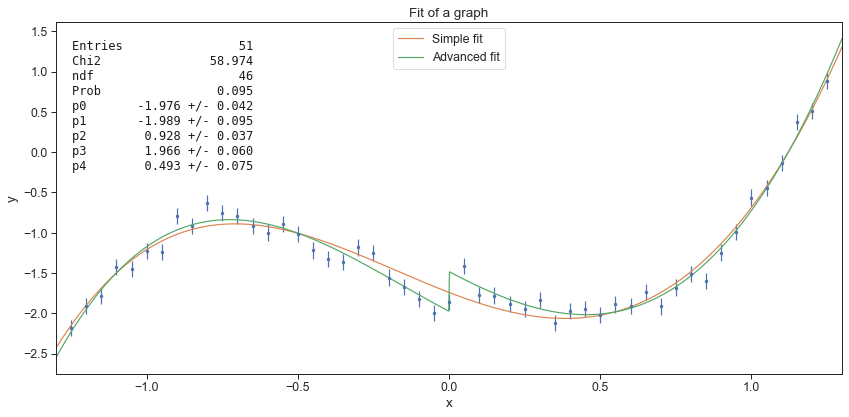

In [52]:
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=12)
fig2.tight_layout()


fig2

and finally save the plot (if save_plots if True):

In [53]:
if save_plots:
    fig2.savefig('Graph.pdf', dpi=600)

*** 

In case you want to export the notebook to a normal python file (.py), you can uncomment the command below (but keep the "`!`") and run the cell. This exports the notebook to a Python file.

In [54]:
!jupyter nbconvert --to script IntroToPlottingAndFitting_original.ipynb

[NbConvertApp] Converting notebook IntroToPlottingAndFitting_original.ipynb to script
[NbConvertApp] Writing 25228 bytes to IntroToPlottingAndFitting_original.py


(In the case that you want to convert back from .py to Notebook.ipynb file, run the following command:
`jupyter nbconvert --to notebook IntroToPlottingAndFitting.py` in a terminal. In case you want to do it automatically in the Python script, add the line `os.system("jupyter nbconvert --to notebook IntroToPlottingAndFitting.py")`